
# README: Explainability Lab — Week 2, Day 3

Notebook: 03_gradcam_explainability.ipynb
Project: PneumoDetect — AI-Assisted Pneumonia Detection
Lab Theme: "Learning What the Model Sees" (Explainability Prototype)
Purpose:
This notebook demonstrates Grad-CAM (Gradient-weighted Class Activation Mapping)
for visualizing which regions of a chest X-ray most influence the model's
pneumonia predictions.

Objectives:
1. Implement Grad-CAM using hooks on the last convolutional layer.
2. Generate class activation heatmaps for sample test images.
3. Overlay heatmaps on original X-rays to validate model focus areas.
4. Compare model attention before and after fine-tuning.

Expected Outcome:
Heatmaps should highlight lung fields rather than image borders,
providing visual interpretability for the AI model’s decision process.

Output Directory:
reports/week2_gradcam_samples/



In [13]:
# Add script to include project root in sys.path

import sys
from pathlib import Path

# Add project root (one level up from notebooks/)
project_root = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path.cwd().parent
sys.path.append(str(project_root))

In [14]:
# ============================================================
# 1. Setup and Imports
# ============================================================

from src.gradcam import GradCAM
from torchvision import models, transforms
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Ensure deterministic behavior for reproducibility
torch.manual_seed(42)

# Create output directory for Grad-CAM visualizations
output_dir = Path("reports/week2_gradcam_samples")
output_dir.mkdir(parents=True, exist_ok=True)


In [15]:
# ============================================================
# 2. Load Model and Initialize Grad-CAM
# ============================================================

# Load pretrained model (fine-tuned checkpoint if available)
model_path = Path("saved_models/resnet50_finetuned.pt")
model = models.resnet50(weights="IMAGENET1K_V1")

if model_path.exists():
    model.fc = torch.nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    print(f"Loaded fine-tuned weights from {model_path}")
else:
    print("Fine-tuned weights not found; using ImageNet pretrained model.")

model.eval()
gradcam = GradCAM(model, target_layer_name="layer4")


Fine-tuned weights not found; using ImageNet pretrained model.


In [16]:
# ============================================================
# 3. Define Preprocessing and Load Test Images
# ============================================================

# Transformation consistent with training pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load a few sample test X-rays
test_dir = Path("data/rsna_subset/test_images")
sample_paths = list(test_dir.glob("*.png"))[:4]

if not sample_paths:
    print("No test images found; using synthetic gray images for demo.")
    sample_paths = []
    for i in range(4):
        dummy = Image.new("RGB", (224, 224), color="gray")
        dummy_path = output_dir / f"synthetic_{i}.png"
        dummy.save(dummy_path)
        sample_paths.append(dummy_path)


No test images found; using synthetic gray images for demo.


In [17]:
# ============================================================
# 4. Generate and Save Grad-CAM Heatmaps
# ============================================================

results = []

for img_path in sample_paths:
    img = Image.open(img_path).convert("RGB")
    tensor = transform(img).unsqueeze(0)

    # Compute Grad-CAM heatmap
    heatmap = gradcam.generate(tensor)

    # Save overlay visualization
    overlay_path = output_dir / f"{img_path.stem}_overlay.png"
    gradcam.save_overlay(img, heatmap, str(overlay_path))

    results.append((img_path, overlay_path))

print(f"Generated {len(results)} Grad-CAM overlays → {output_dir.resolve()}")


Generated 4 Grad-CAM overlays → /Users/adrianadewunmi/VSCODE/AI-Assisted-Pneumonia-Detection-Project/notebooks/reports/week2_gradcam_samples


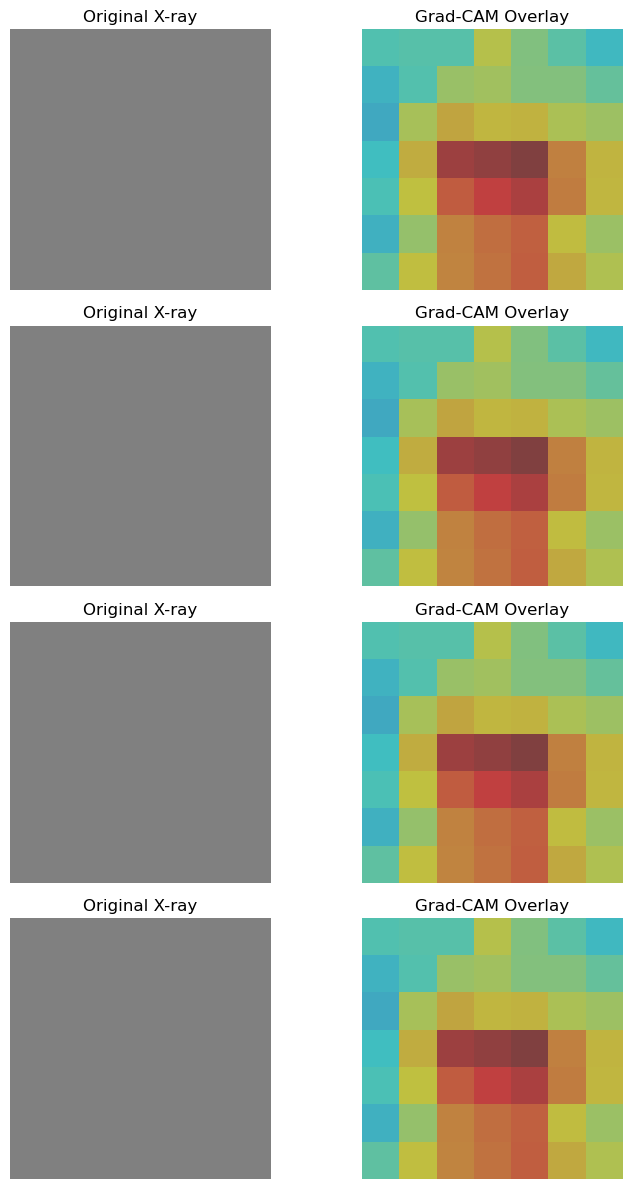

In [18]:
# ============================================================
# 5. Display Comparison Grid (Original vs Grad-CAM)
# ============================================================

cols = 2
rows = len(results)
fig, axes = plt.subplots(rows, cols, figsize=(8, rows * 3))

for i, (orig_path, overlay_path) in enumerate(results):
    orig = Image.open(orig_path)
    overlay = Image.open(overlay_path)

    axes[i, 0].imshow(orig)
    axes[i, 0].set_title("Original X-ray")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(overlay)
    axes[i, 1].set_title("Grad-CAM Overlay")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()
